In [0]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files
from IPython.display import Image
from google.colab import files

uploaded = files.upload()

Saving sem_senna.png to sem_senna.png
Saving sem_senna2.png to sem_senna2.png


# SENNA

**SENNA** *(Semantic/Syntactic Extraction using a Neural Network Architecture)* – архитектура нейронной сети, позволяющая достигнуть state-of-the-art результатов в нескольких задачах обработки текстов. 

* POS (part-of-speech tagging)
* CHK (chunking)
* NER (named entity recognition)
* SRL (semantic role labeling)

Предложен в статье [Natural Language Processing (almost) from Scratch](https://arxiv.org/pdf/1103.0398.pdf) (R. Collobert, J.  Weston, L. Bottou, M. Karlen, K. Kavukcuoglu, P. Kuksa, 2011).

Основное преимущество подхода ("almost from scratch") — не нужно генерировать фичи под каждую из задач, NN сама выучивает "внутренние представления" (~ эмбеддинги). При желании можно добавить фичи самостоятельно.

## Архитектура

SENNA — многослойная сеть прямого распространения. Как и любую такую сеть, ее можно представить в виде комбинации функций, каждая из которых соответствует какому-либо слою.

$$f_\theta(\cdot) = f_\theta^L(f_\theta^{L-1}(\dots f_\theta^1(\cdot)\dots)) $$

### Window-approach 


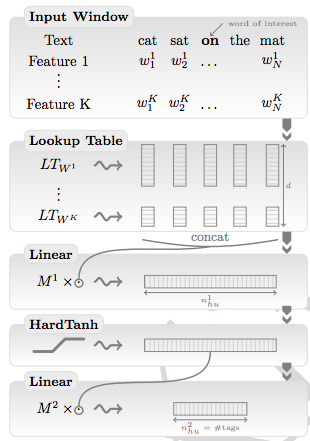

In [0]:
Image('sem_senna.png')

1. Первый слой — Lookup Table, $LT_W(\cdot)$

  * $LT_W(w) = \langle W_w^1\rangle$
  * Слова кодируются индексами из словаря $D$ с помощью one-hot encoding
  * $d_{wrd}$ — размер вектора, соответствующего слову (гиперпараметр)
  * $d_{win}$ — размер окна (гиперпараметр). В данном подходе всегда используется нечетное число.
  * По краям предложения добавляются символы padding с обеих сторон в количестве $(d_{win} - 1)/2$
  * Для незнакомых слов также вводится специальный символ
  * $W$ — матрица параметров, которые должна выучить сеть, $W \in \mathbb{R}^{d_{wrd}\times|D|}$
  * $\langle W_w^1\rangle \in \mathbb{R}^{d_{wrd}}$ — W-тый столбец матрицы W
  * $T$ — количество слов в последовательности
  * Выход слоя $LT_W(\cdot)$ — матрица:  
  $LT_W([w_1^T]) = \left( \langle W^1_{[w]_1}\rangle \langle W^1_{[w]_2}\rangle \dots \langle W^1_{[w]_T}\rangle \right)$
  * Т.е. эмбеддинги слов из окна конкатенируются, и это подается на вход следующему слою. Размер  матрицы, которую выдет lookup table — $d_{wrd} \times d_{win}$
  * Если мы добавляем какие-то фичи — результатом будет конкатенация выходов lookup table для каждой
  
  
  2. Второй слой — линейная функция
  
    * $f_\theta^l = W^lf^{l-1}_\theta + b^l$
    * Параметры: $W^l \in \mathbb{R}^{n^l_{hu} \times n^{l-1}_{hu}}$ и $b \in \mathbb{R}^{n^l_{hu}}$
    * $n^l_{hu}$ — гиперпараметр, количество нейронов (hidden units) на $l$-ом слое
    
3. Скрытый слой. Нелинейная функция активации — гиперболический тангенс
   *  $\left[ f^l_\theta \right]_i = HardTanh \left( \left[ f^{l-1}_\theta \right]_i\right)$
   
  
4. Выходной слой — SoftMax
 
   *  Размер выходного слоя $L =$ количеству возможных меток (например, POS-тегов)
   *  Каждый output — это оценка (score) соответствующего тега  
 
 
## Sentence Approach



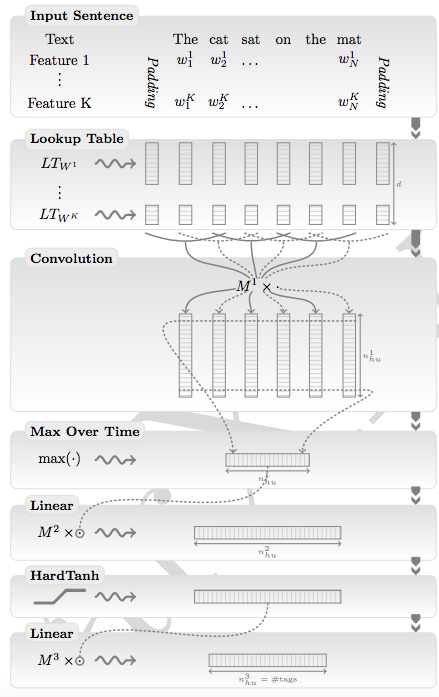

In [0]:
Image('sem_senna2.png')

Лучше работает для задачи маркирования семантических ролей, т.к. предикат может быть далеко от своего аргумента и не попасть в окно.

1. Lookup Table
2. Сверточный слой — извлекает локальный контекст для каждого слова
3. Max Over Time по всему предложению — размерность выхода сверточного слоя зависит от размера предложения
4. Дальше как раньше (линейная функция → нелинейная → линейная)


## Word-level Log-likelihood

$$ p(i|x, \theta) = \frac{exp^{f_\theta(x)_i}}{\sum_jexp^{f_\theta(x)_j}}$$ 
$$ p(y|x, \theta) = f_\theta(x)_y - logadd_jf_\theta(x)_j$$

* $x$ — инпут
* $\theta$ — параметры модели
* $i$ — номер тега
* $f_\theta(x)_i$ — оценка для i-того тега, которую выдала модель
* Недостаток: не принимаем во внимание теги соседних слов. Для этого вводим дополнительный параметр transition score от i-того до j-того тега и считаем sentence-level log-likelihood (подробнее см. в статье).


## Задача POS-tagging
ставится как задача многоклассовой классификации: 
* $T$ - количество различных тегов частей речи (каждое слово $w$ относится к одному из $T$ классов)
* для каждого слова из train формируется вектор признаков 
* NN обучается по всем векторам признаков каждого слова из train 

### Подход к решению 
Window approach network, раздел 3.3.1 в статье.
1. Каждое слово представляется эмбеддингом размерности $d$;
2. Для каждого слова формируется окно длины $k$ из $(k-1)/2$ соседних слов слева от данного слова  и $(k-1)/2$ соседних слов справа от данного слова, $k$ – нечетное. (Если для слова невозможно найти соседние слова, используется padding.)
3. Для каждого слова формируется вектор признаков, состоящий из конкатенированных эмбеддингов слов из левого окна, данного слова и слов из правого окна. Итоговая размерность вектора признаков – $d \times k$. Этот вектор подается на вход нейронной сети;
4. Обучается нейронная сеть, имеющая один скрытый слой с $n_h$ нейроннами и нелинейной функцией активации $\theta$;
5. На выходном слое нейронной сети решается задача классификации на |T| классов. 


Предобученные эмбеддинги Facebook: https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.ru.vec

Данные: https://www.dropbox.com/s/n5pgf9nu50jvwra/unamb_sent_14_6.conllu

In [0]:
! wget https://www.dropbox.com/s/n5pgf9nu50jvwra/unamb_sent_14_6.conllu
! wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.ru.vec

--2019-02-20 16:28:39--  https://www.dropbox.com/s/n5pgf9nu50jvwra/unamb_sent_14_6.conllu
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/n5pgf9nu50jvwra/unamb_sent_14_6.conllu [following]
--2019-02-20 16:28:39--  https://www.dropbox.com/s/raw/n5pgf9nu50jvwra/unamb_sent_14_6.conllu
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2555e1c8c18e04daed16fd46a8.dl.dropboxusercontent.com/cd/0/inline/AbtHRIM_q5f2vMVF8YKCU8SUCBTlHSGaK3av2CP741TUWFgoW01ZyYWTGVxC_w_voLQPZIzrsBoqx9BCbytllUk61tencqoW1uOf5e6TP5FwEg/file# [following]
--2019-02-20 16:28:39--  https://uc2555e1c8c18e04daed16fd46a8.dl.dropboxusercontent.com/cd/0/inline/AbtHRIM_q5f2vMVF8YKCU8SUCBTlHSGaK3av2CP741TUWFgoW01ZyYWTGVxC_w_voLQPZIzrsBoqx9BCbytllUk61tencqoW1uOf5e6TP

### 1. Составляем обучающую выборку 

- считываем выборку 
- делим на train, test по предложениям
- каждое предложение внутри каждого из множества разделям на слова (оставляем структуру предложения в виде list, потому что нам потребуется контекст: слова слева и справа)

In [0]:
path = 'unamb_sent_14_6.conllu'
project_path = os.getcwd()

In [0]:
from nltk.corpus.reader import ConllCorpusReader
pos_corpus = ConllCorpusReader(project_path, fileids = path, 
                               columntypes = ['ignore', 'words', 'ignore', 'pos', 'chunk'])
sents = list(pos_corpus.iob_sents())

In [0]:
pos_tags = set([pos for text in sents for word, pos, chunk in text])

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(sents, test_size=0.25)
sent_train = [[word[0].lower() for word in sent]for sent in train]
label_train = [[word[1] for word in sent] for sent in train]
sent_test = [[word[0].lower() for word in sent]for sent in test]
label_test = [[word[1] for word in sent] for sent in test]

### 2. Считываем эмбеддинги

Далее будем подавать эмбеддинги на вход Embedding layer в поле weights (матрица). Матрица train при этом должна быть integer-encoded (слову соответствует индекс), т.е. строка матрицы — контекст слова, для которого есть POS-метка. Каждому слову из окна соответствует один столбец.

- Будем хранить не все эмбеддинги, а только для слов, которые встречаются в train и test: надо сохранить сами эмбеддинги в матрицу (word_embeddings), и запомнить соответствие «слово — индекс в матрице» (word_2_idx)
- Будьте внимательны с кодировкой .de(en)code('utf-8')
- Не забудем о PADDING, UNKNOWN (для некоторых слов не существует контекста, в этом случае эмбеддинг будет из нулей; для некоторых слов не найдется предобученного эмбеддинга, создадим для таких слов эмбеддинг np.random.uniform)

In [0]:
# составляем словарь
words = set()

for sent_set in [sent_train, sent_test]:
    for sentence in sent_set:
        for token in sentence:
            words.add(token.lower())

In [0]:
from tqdm import tqdm
import numpy as np

word_2_idx = {}
word_embeddings = []
with open('wiki.ru.vec', 'rb') as f :
    for line in tqdm(f):
        values = line.split()
        if len(values) != 301:
            continue
            
        if len(word_2_idx) == 0:
            word_2_idx["padding"] = len(word_2_idx)
            vector = np.zeros(len(values)-1) 
            word_embeddings.append(vector)

            word_2_idx["unknown"] = len(word_2_idx)
            vector = np.random.uniform(-0.25, 0.25, len(values)-1)
            word_embeddings.append(vector)
            values = line.split()
            
        if  values[0].lower().decode('utf-8') in words:
            vector = np.asarray(values[1:], dtype='float32')
            word_embeddings.append(vector)
            word_2_idx[values[0].lower()] = len(word_2_idx)
            
            
word_embeddings = np.array(word_embeddings)

1888424it [00:50, 37719.97it/s]


In [0]:
word_embeddings.shape, len(word_2_idx), len(words)

((70789, 300), 70789, 79791)

### 3. Составляем train

- Сформируем окно для каждого слова размера $k$
- Закодируем каждое слово из контекста индексом, соответсвующим этому слову в матрице эмбеддингов
- Не забываем про padding, unknown

### 4. Составляем test
- Кодируем каждый label индексом

In [0]:
WINDOWSIZE = 5
UNKNOWN_IDX = word_2_idx['unknown']
PADDING_IDX = word_2_idx['padding']

In [0]:
def get_context(tgt_word_idx, sentence, windowsize):
    context = []  
    for word_position in range(tgt_word_idx - windowsize, tgt_word_idx + windowsize+1):
        if word_position < 0 or word_position >= len(sentence):
            context.append("padding")
            continue
        word = sentence[word_position]
        context.append(word)   
    return context


# сюда будем записывать не сами слова, а индекс эмбеддинга
X_train = []

for sentence in sent_train:
    for tgt_word_idx in range(len(sentence)):
        tgt_word_context = get_context(tgt_word_idx, sentence, WINDOWSIZE//2)
        X_train.append([word_2_idx.get(word.encode('utf-8'), UNKNOWN_IDX) for word in tgt_word_context])

        
label_2_idx = {}
for label in pos_tags:
    label_2_idx[label] = len(label_2_idx)
y_train = []
for el in label_train:
    y_train.extend([label_2_idx.get(label) for label in el])
    
X_train = np.array(X_train)
y_train = np.array(y_train)

### 5. Обучаем NN


In [0]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Embedding

n_in = X_train.shape[1] # размер окна
n_out = len(label_2_idx) # количество классов

# trainable=False — используем готовые эмбеддинги, не дообучаем
words_input = Input(shape=(n_in,), dtype='int32', name='words_input') # каждый вход — окно из n слов

words = Embedding(input_dim=word_embeddings.shape[0], output_dim=word_embeddings.shape[1], 
                  weights=[word_embeddings], trainable=False)(words_input)

words = Flatten()(words)  # вытягивает матрицу в длинный вектор

output = Dense(64, activation='tanh')(words)
output = Dense(n_out, activation='softmax')(output)

model = Model(input=[words_input], output=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam')
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words_input (InputLayer)     (None, 5)                 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 5, 300)            21236700  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                96064     
_________________________________________________________________
dense_2 (Dense)              (None, 14)                910       
Total params: 21,333,674
Trainable params: 96,974
Non-trainable params: 21,236,700
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [0]:
model.fit(X_train, y_train, nb_epoch= 2, batch_size = 32,  validation_split = 0.1)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 308914 samples, validate on 34324 samples
Epoch 1/2
308914/308914 [==============================] - 39s 125us/step - loss: 0.2390 - val_loss: 0.1882
Epoch 2/2
308914/308914 [==============================] - 39s 125us/step - loss: 0.1603 - val_loss: 0.1641


### 6. Делаем предсказание для test
- Составляем test
- Применяем модель (предсказываем POS-тег для каждого слова в тестовой выборке)
- Смотрим на качество

In [0]:
X_test = []

for sentence in sent_test:
    for tgt_word_idx in range(len(sentence)):
        tgt_word_context = get_context(tgt_word_idx, sentence, WINDOWSIZE//2)
        X_test.append([word_2_idx.get(word.encode('utf-8'), UNKNOWN_IDX) for word in tgt_word_context])
        
y_test = []
for el in label_test:
    y_test.extend([label_2_idx.get(label) for label in el])
    
X_test = np.array(X_test)
y_test = np.array(y_test)

In [0]:
idx_2_label = {v: k for k, v in label_2_idx.items()}
pred = model.predict(X_test)
t = np.array([idx_2_label[i] for i in y_test])
p = np.array([idx_2_label[i] for i in np.argmax(pred, axis=1)])

In [0]:
from sklearn.metrics import classification_report
print(np.mean(t==p)) # accuracy
print(classification_report(t, p))

0.9448948358039267
              precision    recall  f1-score   support

         ADJ       0.92      0.94      0.93     11842
         ADP       0.99      0.99      0.99     10711
         ADV       0.89      0.87      0.88      3292
        CONJ       0.97      0.95      0.96      5375
         DET       0.97      0.95      0.96      3217
        INTJ       0.74      0.51      0.60       118
        NOUN       0.97      0.96      0.97     30321
         NUM       0.84      0.85      0.84      2600
        PART       0.91      0.92      0.92      2168
        PRON       0.98      0.95      0.97      2258
       PROPN       0.85      0.88      0.87      3701
       PUNCT       0.96      0.99      0.98     22956
        VERB       0.96      0.97      0.96     10378
           X       0.76      0.67      0.72      5408

   micro avg       0.94      0.94      0.94    114345
   macro avg       0.91      0.89      0.90    114345
weighted avg       0.94      0.94      0.94    114345

